## Setup

This section installs and imports some required packages.

In [1]:
!pip uninstall tensorflow -yq
!pip install tensorflow-gpu==2.0 gpustat tqdm -Uq

In [0]:
import itertools
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm.notebook import trange
import plotly.graph_objects as go

import tensorflow.compat.v2 as tf
from tensorflow.keras import preprocessing
from tensorflow.keras import layers

# Word2Vec Models in TF 2.0

In [3]:
!gpustat

bb3ace716314             Mon Dec 30 08:40:17 2019  418.67
[0] Tesla P100-PCIE-16GB | 34'C,   0 % |     0 / 16280 MB |


# Skip-gram Model

Learning and exploring distributed word representations using a Skip-gram model in TensorFlow 2.0.

**Model Hyperparameters**

In [0]:
EMBEDDING_SIZE = 7
WINDOW_SIZE = 4

## Generating Synthetic Dataset

It takes too much time to train on a whole dataset, with a large corpus and vocabulary size.

Hence, we will generate a synthetic dataset of some simple sentences.

In [5]:
animals = ["cat","dog","goat","elephant","eagle","zebra","rhino", "hippo"]
actions = ["sat","stood","jumped","slept","rolled"]
furniture = ["mat","rug","sofa","bed", "chair","floor"]
modifier = ["a", "the", "one", "that"]

# Generate all combinations of animal, action and furniture
animal_corpus = [
    "{} {} {} on {} {}".format(x[0], x[1], x[2], x[3], x[4]) for x in itertools.product(modifier, animals, actions, modifier, furniture)
]

print("There are", len(animal_corpus), "sentences in the corpus.")

There are 3840 sentences in the corpus.


### Tokenize the Sequences

Note that the Tokenizer starts numbering words with `1`.  Hence, we actually have `vocabulary_size+1` words.  The zero-th word is considered to be the `Out-of-Vocabulary` token.

In [6]:
tokenizer = preprocessing.text.Tokenizer(num_words=1000,
                                         lower=True)
tokenizer.fit_on_texts(animal_corpus)

vocab_size = len(tokenizer.word_index)
print("Vocab size:", vocab_size)

sequences = tokenizer.texts_to_sequences(animal_corpus)

Vocab size: 24


<img src="http://mccormickml.com/assets/word2vec/training_data.png" width=50% align="right" style="margin-right: 0px;">

## Generate Skipgram pairs

The Skipgram algorithm involves learning word representations using a word similarity task. Hence, we will need to transform a sequence of word token (list of integers) into **tuples** of words of the form:

* `(word, word_same_window)`, with label `1` (positive samples)
* `(word, random_word)`, with label `0` (**negative samples**)

Read more about Skipgram in the paper [*Efficient Estimation of Word Representations in Vector Space* (Mikolov et al., 2013)](https://arxiv.org/abs/1301.3781)


In [7]:
pairs, labels = [], []

for sequence in sequences:
    c, l = preprocessing.sequence.skipgrams(sequence,
                                            vocab_size+1,
                                            window_size=WINDOW_SIZE,
                                            negative_samples=1,
                                            shuffle=True)
    for i in range(len(c)):
        pairs.append(c[i])
        labels.append(l[i])
    
print("There are {} (context,target) pairs in the dataset".format(len(pairs)))

There are 215040 (context,target) pairs in the dataset


In [0]:
# convert to numpy arrays for speed
pairs = np.array(pairs)
labels = np.array(labels)

## Build Model

Use tf.keras to build a model from layers.

In [0]:
# two inputs: target and context
target_word = layers.Input(shape=(1,), name="target_word")
context_word = layers.Input(shape=(1,), name="context_word")

# Embedding layer contains a vector for every word
embedding_layer = layers.Embedding(vocab_size+1,
                                   EMBEDDING_SIZE,
                                   input_length=1,
                                   name="embedding_layer")

# "head" for target word
target_embedding = embedding_layer(target_word)
target_embedding = layers.Reshape((EMBEDDING_SIZE,))(target_embedding)

# "head" for context word
context_embedding = embedding_layer(context_word)
context_embedding = layers.Reshape((EMBEDDING_SIZE,))(context_embedding)

# perform dot product to compare similarity
output = layers.Dot(axes=1,name="word_similarity")([target_embedding,
                                                context_embedding])

output = layers.Dense(1, activation="sigmoid", name="output")(output)

model = tf.keras.models.Model(inputs=[target_word, context_word],
                              outputs=output)

model.compile(loss="binary_crossentropy",
              optimizer="adam")

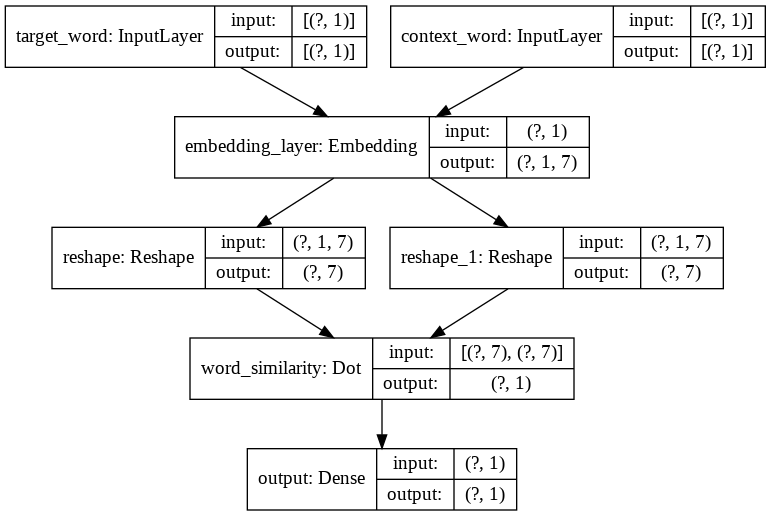

In [10]:
tf.keras.utils.plot_model(model,
                          show_shapes=True,
                          show_layer_names=True,
                          rankdir="TB")

## Train Model

In [0]:
def train_model(pairs, labels, epochs, print_interval):
    for i in trange(epochs//print_interval, desc="Training Progress"):
        h = model.fit(x=pairs, y=labels, batch_size=256,
                      epochs=print_interval,
                      verbose=0, shuffle=True)
        print("Epoch:", (i+1) * print_interval,
              "- Loss:", round(h.history["loss"][-1], 4))

In [12]:
train_model([pairs[:,0], pairs[:,1]], labels,
            epochs=50,
            print_interval=10)

Epoch: 10 - Loss: 0.6231
Epoch: 20 - Loss: 0.6231
Epoch: 30 - Loss: 0.623
Epoch: 40 - Loss: 0.6231
Epoch: 50 - Loss: 0.6229



## Visualize Word Vectors

In [0]:
word_index = dict([(value, key) for key, value in tokenizer.word_index.items()])
word_index = [""] + list(word_index.values())

In [14]:
category_colors = {"animals": "green", 
                   "actions": "blue",
                   "furniture": "red"}

colors = []

for i in range(vocab_size+1):
    colors.append("yellow")
    
for word in tokenizer.word_index:
    index = tokenizer.word_index[word]
    if word in animals:
        colors[index] = category_colors["animals"]
    elif word in actions:
        colors[index] = category_colors["actions"]
    elif word in furniture:
        colors[index] = category_colors["furniture"]
        
pca = PCA(n_components=3)
transformed_values = pca.fit_transform(model.get_layer("embedding_layer").get_weights()[0])

fig = go.Figure(data=[
    go.Scatter3d(x=transformed_values[:,0],
    y=transformed_values[:,1],
    z=transformed_values[:,2],
    text=word_index,
    mode="markers",
    marker=dict(
        size=5,
        color=colors,
        opacity=0.5
    ))
])

fig.update_layout(
    title="3D Plot of Word Vectors after PCA",
)

fig.show()

# CBOW Model

In the CBOW (Continuous Bag of Words) model, the surrounding words are used to predict the target (center) word.

### Generate Training Data

In [15]:
window_size = 2

def make_cbow_data(sequences, window_size):
    X, y = [], []
    num_classes = len(np.unique(np.hstack(sequences)))+1
    for this_sequence in sequences:
        for output_index, this_word in enumerate(this_sequence):
            this_input = []
            y.append(tf.keras.utils.to_categorical(this_word, num_classes))
            input_indices = [output_index - i for i in range(window_size,0,-1)]
            input_indices += [output_index + i for i in range(1, window_size+1)]
            for i in input_indices:
                this_input.append(this_sequence[i] if i >= 0 and i < len(this_sequence) else 0)
            X.append(this_input)
    return np.array(X),np.array(y)
                
cbow_X, cbow_y = make_cbow_data(sequences, window_size)
print("Inputs: cbow_X shape: {}".format(cbow_X.shape))
print("Targets: cbow_y shape: {}".format(cbow_y.shape))

Inputs: cbow_X shape: (23040, 4)
Targets: cbow_y shape: (23040, 25)


In [0]:
class MeanLayer(tf.keras.layers.Layer):
  def __init__(self):
    super(MeanLayer, self).__init__()
  def build(self, input_shape):
    pass
  def call(self, input):
    return tf.math.reduce_mean(input, axis=1)

In [0]:
inputs = layers.Input((window_size * 2,))

output = layers.Embedding(vocab_size+1,
                          EMBEDDING_SIZE,
                          input_length=2*window_size,
                          name="embedding_layer")(inputs)
output = MeanLayer()(output)
output = layers.Dense(vocab_size+1, activation="softmax")(output)

model = tf.keras.models.Model(inputs=[inputs], outputs=output)

model.compile(loss="categorical_crossentropy", optimizer="adam")

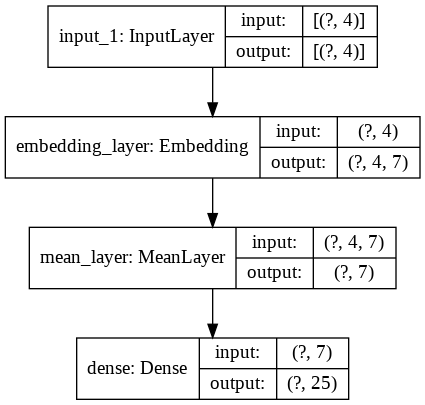

In [18]:
tf.keras.utils.plot_model(model,
                          show_shapes=True,
                          show_layer_names=True,
                          rankdir="TB")

In [19]:
train_model(cbow_X, cbow_y,
            epochs=100,
            print_interval=10)

Epoch: 10 - Loss: 1.7986
Epoch: 20 - Loss: 1.4753
Epoch: 30 - Loss: 1.4095
Epoch: 40 - Loss: 1.3923
Epoch: 50 - Loss: 1.3853
Epoch: 60 - Loss: 1.3822
Epoch: 70 - Loss: 1.3803
Epoch: 80 - Loss: 1.3794
Epoch: 90 - Loss: 1.3787
Epoch: 100 - Loss: 1.3783



In [20]:
pca = PCA(n_components=3)
transformed_values = pca.fit_transform(model.get_layer("embedding_layer").get_weights()[0])

fig = go.Figure(data=[
    go.Scatter3d(x=transformed_values[:,0],
    y=transformed_values[:,1],
    z=transformed_values[:,2],
    mode="markers",
    text=word_index,
    marker=dict(
        size=5,
        color=colors,
        opacity=0.5
    ))
])

fig.update_layout(
    title="3D Plot of Word Vectors after PCA",
)

fig.show()

# Conclusion

We've seen how to implement the two classic Word2Vec algorithms:

![word2vec](https://www.researchgate.net/profile/Nailah_Al-Madi/publication/319954363/figure/fig1/AS:552189871353858@1508663732919/CBOW-and-Skip-gram-models-architecture-1.png)